#    **Aerosol particles and cloud droplets in Ny-Ålesund, Svalbard**

###                ***Evaluating NorESM at an Arctic site***




***


#### *Ingvild Sofie Sundby Aukan*
ingvilda@met.no,
eScience Tjärnö,
02.12.2022,
Group assistant: Sara

***


> #### **Abstract**
 > In this report, I show the work and results of my project for the eScience course in Tjärnö November 2022. For this project, I investigated key characteristics and relationships relevant for aerosol-cloud interactions in the Arctic. I used measurement data from the Zeppelin Observatory in Ny-Ålesund, Svalbard. From this dataset, which spanned the period 26 November 2015 to 4 February 2018, I looked at cloud particles measured by a fog monitor, cloud residuals measured behind a GCVI that only operated when a cloud was detected, and total particle number concentration from a whole-air inlet. In addition, I looked at cloud droplet and particle number concentrations from NorESM. 
 I found that NorESM was able to capture the seasonal distribution of cloud droplet number concentration. The relationship between cloud droplet and particle number concentrations showed some varying results between cloud particles from the fog monitor, cloud residuals from the GCVI and cloud droplets and particles in NorESM. The cloud residuals agreed quite well with the particle number concentration, even when including small particles, and especially at low concentrations. The fog monitor seemed to yield fewer cloud particles compared to total particles from the whole-air inlet. For NorESM, N50 seemed to be the best cloud droplet proxy.
 > 

## **Introduction**
Aerosols impact radiative forcing directly by absorbing and reflecting radiation, and indirectly by serving as cloud condensation nuclei (CCN). Certain aerosols act as ice nucleating particles (IPNs), but in this project I focus on CCNs and warm clouds. Ny-Ålesund is a closed down cole mine settlement, which now mostly hosts researchers and younger brothers. Close by, on a hill, we find the Zeppelin Observatory, which is an observatory for atmospheric research and monitoring. While I only look at data from one specific site, the placement of this observatory, far away from any substantial emission sources, provides a unique insight into the otherwise remote Arctic.
There is a seasonality to Arctic aerosols. For large parts of the year, the air is very pristine, i.e. it does not contain a lot of particles. In the dark season (autumn and winter), particle formation and emissions are limited by the lack of sunlight and direct sources. With changing climate, sea ice loss and altered circulation patterns, Arctic aerosol is a potential subject to change. This in turn will impact radiative forcing directly, and indirectly through aerosol-cloud interactions. As such, being able to properly simulate aerosols characteristics and the role they play in cloud droplet formation is crucial in understanding future Arctic climate. In this short study, I will compare measurement data from the Zeppelin Observatory in Svalbard to NorESM data. With over two years of continuous high resolution measurements, Karllson et al. (2021) provides a unique dataset of aerosol and cloud droplet properties in the Arctic. My personal aim for this project was to get acquainted with this data, as well as to gain insight into the modus operandi of aerosol- and cloud science. A more formal goal was to investigate the differences between the retrieval methods, and compare them with climate model simulations, to see if the model is able to capture some key aspects of aerosol-cloud interactions in the Arctic, especially in terms of the seasonality.

## **Method**


### Data from the Zeppelin station

The measurement data is from the Zeppelin Observatory, located on the Norwegian archipelago of Svalbard, at 78&deg;54'N, 11&deg;53'E. The observatory is at 480 m.a.s.l., and has been found to be in a cloud ~ 16% of the time in 2015-2018 (Karlsson et al. 2021). The data I have used is collected and compiled into NetCDF-files by Linn Karlson et al. (2021) (see web page). It spans the period 26 November 2015 to 4 February 2018, and contains data from a fog monitor, that measures size droplet sizes and visibility, and information about particles from different instruments.
Total particle and cloud residual number size distributions are measured at time intervals between 5-16 minutes by a Differential Mobility Particle Sizer (DMPS) behind different air inlets. 
In addition to the aerosol and cloud data, the dataset contained concurrent meteorological data (temperature, wind etc.) measured at the Zeppelin Observatory. 
#### The inlets -- cloud or no cloud, that is the question.
There are two different types of air inlets. One is an whole-air inlet, which measures all the time. The other is a ground-based counterflow virtual impactor inlet (GCVI), which only operates when a cloud is detected at the station. The GCVI then separates interstitial particles out(non-activated), so that only cloud droplets (activated particles) get sampled. We call these particle *cloud residuals*, indicating that they were activated, and served as CCNs at the time of retrieval. A cloud is defined as when the visibility is lower than 1km. 

The data I got was already treated by Karlsson et al. (2021) to account for specific instrument biases and outliers. Because particles get concentrated inside the GCVI inlet, so that the concentration is larger than for the ambient air, the measured concentrations have to be corrected with an Enrichment factor (Linn Karlssons PhD-thesis, 2022). Also, some particles are measured more efficiently than others, depending on particle size (Shingler et al. 2012). Therefore, we also have to correct for the transmission efficiency.

The dataseries were not filtered for cloud vs non-cloud measurements. Instead, a cloud-flag variable was included, which I had to apply to the different variables. I also filtered out data when the temperature was above -4&deg;C, for when I only wanted to deal with cloud droplets, and not ice crystals.

### NorESM

NorESM is the Norwegian Earth System Model, run by Met Norway.
I was provided with a model run from Sara, which was f09 f09 mg17, nudged run.
From the model output, I extracted the following variables: 
* AWNC: average cloud water number concentration
* AREL: average droplet effective radius
* FREQL: fractional occurance of liquid
* N100, N50 & N30: total number of particles with radius bigger than 100, 50 or 30 nm.

Both AWNC and AREL are weighted by cloud fraction, so to get to the actual value, I had to divide with FREQL. I had a quick look at the data from NorESM at different levels, since the Zeppelin Observatory is at 480 M.A.S.L. I concluded that for my use, it is okay to use the surface level in the model.
The NorESM time series is in hourly data, and goes from 1 January 2015 to 2 January 2018.
### Data handling

The python libraries and functions I used is shown below. I mainly used xarray to do standard data handling procedures, such as cloud- and temperature filtering, resampling (changing time resolution) and extracting time series. A linear regression procedure was imported from sklearn (reference). For integrating size distribution data to number concentrations, I was provided with a function (compute_Nx_ebas_cleaned) by my group instructor Sara Blichner.


In [39]:
# Import necessary libraries and functions

import xarray as xr
from sizedist_utils import compute_Nx_ebas_cleaned  # Made by Sara: size distribution to number concentration integration
import matplotlib.pyplot as plt
import numpy as np
from sklearn.linear_model import LinearRegression

import s3fs
s3 = s3fs.S3FileSystem(key="K1CQ7M1DMTLUFK182APD", 
                       secret="3JuZAQm5I03jtpijCpHOdkAsJDNLNfZxBpM15Pi0", 
                       client_kwargs=dict(endpoint_url="https://rgw.met.no"))
#s3.ls('escience2022')

import warnings
warnings.filterwarnings('ignore')

### **Loading and preparing data**

In [2]:
# Zeppelin data
# ==================================
data1 = xr.open_dataset('/home/jovyan/Data/zeppelin-cloud-aerosol-1_part1.nc4')
data2 = xr.open_dataset('/home/jovyan/Data/zeppelin-cloud-aerosol-1_part2.nc4')


# Cloud flag
data1_cl_mask=data1.where(data1['cloud_flag']=='yes')
data1_no_cl = data1.where(data1['cloud_flag']=='no')

# Filter out cold temperatures (< -4C) to remove ice from observations
data1_cl_mask_warm=data1_cl_mask.where(data1_cl_mask['temperature'] > -4.0)

In [3]:
# NorESM data
#===================================

# Pick variables -- Cloud Properties
varl = ['AWNC', 'AREL', 'FREQL', 'N100','N50', 'N30'] 

path_to_data = 's3://escience2022/Sara/NorESM_nudged_data/postproc/stations/OsloAero_intBVOC_f09_f09_mg17_ssp245/'
postfix = '_OsloAero_intBVOC_f09_f09_mg17_ssp245_2015-01-01_2018-01-01_hour_locations.nc'

def make_file_path_for_var(v,):
    return path_to_data+v+postfix

filelist = [make_file_path_for_var(v) for v in varl]

list_of_s3_obj = [s3.open(s) for s in filelist]


ds = xr.open_mfdataset(list_of_s3_obj)

# Define and add AWNC_incld to dataset
ds['AWNC_incld'] = ds['AWNC']/ds['FREQL']

### **Integrating size distribution to droplet number concentrations**

To get from particle and cloud droplet size distributions to number concentrations, I use a function made by Sara that integrates over the diameters. From here on out, I designate the following names for the data:
* Nx_cloud : Fog monitor - cloud masked cloud particle size distribution, integrated with compute_Nx_ebas_cleaned (d>1e-9)
* Nx_cloudresidual : CVI - variable 'total_aerosol_particle_concentration' in cloud masked data1
* Nx_NorESM : AWNC_incld at level -1, location Zeppelin.

I resampled the observational data to hourly to have the same time resolution as the model data.

In [8]:
# Calculate/extract cloud droplet number concentrations

Nx_cloud =compute_Nx_ebas_cleaned(data1_cl_mask,x=1e-9, var_diam = 'cloud_diameters', v_dNdlog10D='cloud_particle_size_distribution')
Nx_cloud_warm =compute_Nx_ebas_cleaned(data1_cl_mask_warm,x=1e-9, var_diam = 'cloud_diameters', v_dNdlog10D='cloud_particle_size_distribution')
Nx_cloudresidual = data1_cl_mask.total_aerosol_particle_concentration
Nx_cloudresidual_warm= data1_cl_mask_warm.total_aerosol_particle_concentration
Nx_NorESM = ds.isel(lev=-1).sel(location='Zeppelin')['AWNC_incld']


# Resampling to hourly data

Nx_cloud_hourly=Nx_cloud.resample(time='H').mean()
Nx_cloud_warm_hourly=Nx_cloud.resample(time='H').mean()
Nx_cloudresidual_hourly=Nx_cloudresidual.resample(time='H').mean()
Nx_cloudresidual_warm_hourly=Nx_cloudresidual_warm.resample(time='H').mean()


### **Preparing data for cloud droplet to particle number concentration scatter plots**

A way to investigate the relationship between total particle number concentration and cloud droplet number concentration, is to present them in scatterplots. In preparation of that, I calculate the total number of particles, as measured by the whole air inlet, above certain diameters. For this, I still use the integration function *compute_Nx_ebas_cleaned*, and I set the diameter cutoff to 100, 50 and 25 nm. After that, I resample all the relevant time series into daily values, merge to datasets for simplicity, and extract time series that are common for both the observational data and the model data (27.11.2015-02.01.2018). Because the linear regression function I intend to use does not handle NANs, I create datasets where NAN is dropped.

In [9]:
# Calculate N100,N50 and N25 from all_air inlet aerosol particle size distribution

N100_allair=compute_Nx_ebas_cleaned(data1,x=100e-9, var_diam = 'aerosol_diameters', v_dNdlog10D='aerosol_particle_size_distribution')
N50_allair=compute_Nx_ebas_cleaned(data1,x=50e-9, var_diam = 'aerosol_diameters', v_dNdlog10D='aerosol_particle_size_distribution')
N25_allair=compute_Nx_ebas_cleaned(data1,x=25e-9, var_diam = 'aerosol_diameters', v_dNdlog10D='aerosol_particle_size_distribution')


# Make daily means 

N100_allair_daily = N100_allair.resample(time='D').mean()
N50_allair_daily = N50_allair.resample(time='D').mean()
N25_allair_daily = N25_allair.resample(time='D').mean()
Nx_cloud_daily = Nx_cloud.resample(time='D').mean()
Nx_cloudresidual_daily = Nx_cloudresidual.resample(time='D').mean()
ds_daily = ds.resample(time='D').mean()

# Merging obs. variables to get droplet number and particle number in one

N100_daily = xr.merge([Nx_cloud_daily.rename('Nx_cloud'), N100_allair_daily.rename('N100_allair'), Nx_cloudresidual_daily.rename('Nx_cloudresidual')])
N50_daily = xr.merge([Nx_cloud_daily.rename('Nx_cloud'), N50_allair_daily.rename('N50_allair'), Nx_cloudresidual_daily.rename('Nx_cloudresidual')])
N25_daily = xr.merge([Nx_cloud_daily.rename('Nx_cloud'), N25_allair_daily.rename('N25_allair'), Nx_cloudresidual_daily.rename('Nx_cloudresidual')])

#Extracting time series common for obs and model: 2015-11-27 - 2018-01-02

N100_daily = N100_daily.sel(time=slice('2015-11-27','2018-01-02'))
N50_daily = N50_daily.sel(time=slice('2015-11-27','2018-01-02'))
N25_daily = N25_daily.sel(time=slice('2015-11-27','2018-01-02'))
ds_daily = ds_daily.sel(time=slice('2015-11-27','2018-01-02'))

# Remove NAN (for regression function)
N100_daily_nonan=N100_daily.dropna('time')
N50_daily_nonan= N50_daily.dropna('time')
N25_daily_nonan= N25_daily.dropna('time')
ds_nonan = ds_daily.isel(lev=-1).sel(location='Zeppelin').dropna('time')


### **Linear regression**

To make linear regression lines for my scatter plots, I used a linear regression function from Scikit-learn, a Python module integrating a wide range of state-of-the-art machine learning algorithms for medium-scale supervised and unsupervised problems (Pedregosa et al., 2011). It uses ordinary least squares linear regression.


## **Results**

### **Recreating the annual median/mean of cloud particle and residual concentration, as shown in Karlsson et al. (2021)**

As a first look at the data, I wanted to recreate a plot made by Nilsson et al. (2021), showing monthly mean and median values of the cloud particle and cloud residual number concentration, as measured by the fog monitor and the GCVI respectively. I encountered some problems doing this, because following the description in the paper yielded a different result for me. However, after some trying and failing, I got something similar, which is shown in the figure below. The way I got to this was to divide the *total_aerosol_particle_concentration* from the cloud masked data (which should correspond to the GCVI cloud residual concentration) with the transmission efficiency. The discrepancies between the description in the paper and my approach is discussed later in this report.
Regardless, this figure shows an annual cycle of cloud particles and cloud residuals as expected, with a slow increase during spring, peak in May, followed by a decrease through summer and autumn. It also is meant to show that the instruments agree quite well. I also included the mean cloud droplet concentration from NorESM, at the surface level, which shows higher values for the whole year. 

Text(0.1, -0.1, 'Fig.1: Yearly mean and median number concentration of cloud particles (blue), cloud residuals (orange) and cloud droplets from NorESM (green)')

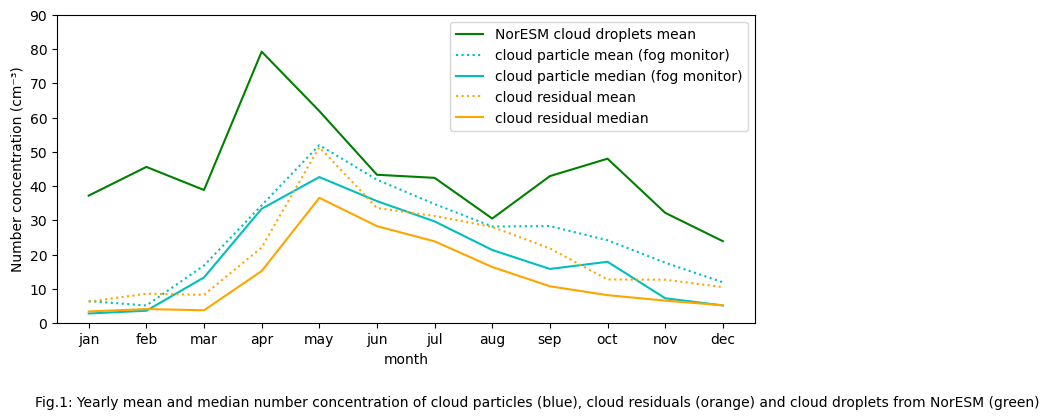

In [32]:
fig, ax = plt.subplots(1, figsize=[9,4])

Nx_NorESM.groupby('time.month').mean(keep_attrs=True).plot(label= 'NorESM cloud droplets mean', c='g')

Nx_cloud.groupby('time.month').mean(keep_attrs=True).plot(label='cloud particle mean (fog monitor)',linestyle=':', c='c')
Nx_cloud.groupby('time.month').median().plot(label='cloud particle median (fog monitor)', c='c')

da = data1_cl_mask.total_aerosol_particle_concentration

da_plt = da/data1['transmission_efficiency_factor']

da_plt.groupby('time.month').mean(keep_attrs=True).plot(label= 'cloud residual mean', linestyle=':', c='orange')
da_plt.groupby('time.month').median(keep_attrs=True).plot(label= 'cloud residual median', c='orange')

plt.ylim([0,90])
plt.xticks(np.arange(1,13), ['jan', 'feb', 'mar', 'apr', 'may', 'jun', 'jul', 'aug', 'sep', 'oct', 'nov', 'dec'])

plt.legend()
plt.ylabel('Number concentration (cm⁻³)')
plt.figtext(0.1, -0.1,'Fig.1: Yearly mean and median number concentration of cloud particles (blue), cloud residuals (orange) and cloud droplets from NorESM (green)')

### **Histograms of droplet number concentrations for each season**

Here, I produce histograms showing how often a certain concentration of cloud droplets (#/cm³) appears in the different datasets. I compare measurements from the fog monitor and the GCVI/DPMS with cloud droplets from the NorESM run. For this plot, I wanted to use as much of the data as possible, so I included the whole time series from the NorESM run, and normalized the data so that all values for each data set sums up to 1 within each season. 

Text(0, 0, 'Fig.2: Normalized distribution of number concentration for each season. Cloud particles in blue, cloud residuals in orange and cloud droplets from NorESM in green.')

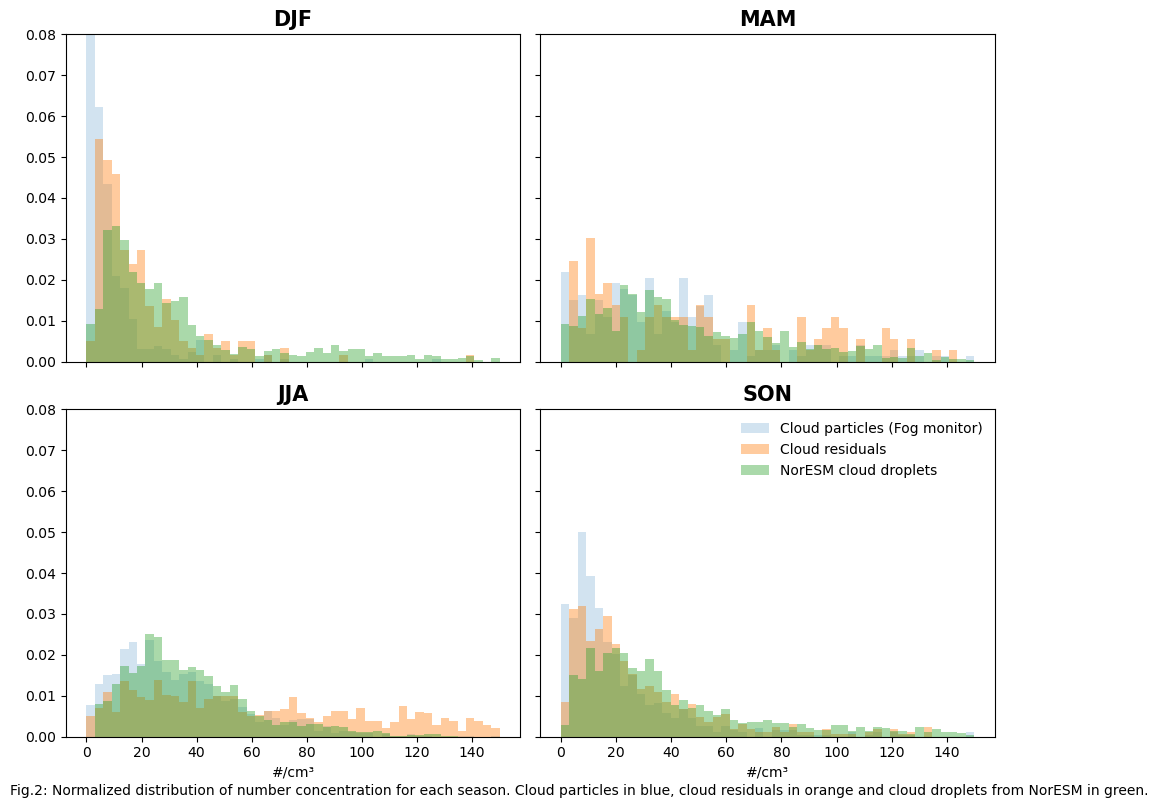

In [35]:
# Group by seasons

ds_seasons = ds.groupby('time.season')
Nx_cloud_seasons = Nx_cloud_hourly.groupby('time.season')
Nx_cloudresidual_seasons = Nx_cloudresidual_hourly.groupby('time.season')
Nx_cloud_warm_seasons = Nx_cloud_warm_hourly.groupby('time.season')
Nx_cloudresidual_warm_seasons = Nx_cloudresidual_warm_hourly.groupby('time.season')


season_str=['DJF', 'MAM', 'JJA', 'SON']



# Plot histograms with subplots of each season.

fig, axs = plt.subplots(2,2, sharex=True, sharey=True, figsize=(10, 8))


for n_ax, ax in zip(range(0, 4), axs.flatten()):

    Nx_cloud_warm_seasons[season_str[n_ax]].plot.hist(density=True,alpha=0.2, bins=np.linspace(0,150,50), label='Cloud particles (Fog monitor)', ax = ax )
    Nx_cloudresidual_warm_seasons[season_str[n_ax]].plot.hist(density=True,alpha=0.4, bins=np.linspace(0,150,50), label='Cloud residuals', ax = ax)
    ds_seasons[season_str[n_ax]].isel(lev=-1).sel(location='Zeppelin')['AWNC_incld'].plot.hist(density=True,alpha=0.4, bins=np.linspace(0,150,50), ax= ax, label='NorESM cloud droplets')
    
    
    if n_ax==3:
        ax.legend(frameon=False)
    if n_ax>=2:
        ax.set_xlabel('#/cm³')
    else:
        ax.set_xlabel('')
    plt.ylim([0,0.08])
    ax.set_title(season_str[n_ax], fontweight='bold', fontsize=15)
plt.tight_layout()
plt.figtext(0, 0,'Fig.2: Normalized distribution of number concentration for each season. Cloud particles in blue, cloud residuals in orange and cloud droplets from NorESM in green.')

### **Scatter plots of cloud droplets against total particles**

To investigate the relationship between particle size and droplet number, I plot the total concentration of particles above certain radii agains total droplet concentration. I do this for NorESM, the fog monitor and the cloud residual measurements separately. All the data has been resampled to daily values, and sliced into a time series that was covered in both the observational and modelled data. The left panel (in green) shows NorESM: total particle concentration on the x-axis and total cloud number on the y-axis. In the middle (blue), we have total particle concentration from the whole-air inlet on the x-axis, and cloud droplet concentration as measured by the fog monitor on the y-axis. To the right (orange), the x-axis is the same, but the y-axis is cloud droplet concentration as measured by the GCVI/DMPS (cloud residuals). 

Text(0, 0, 'Fig.3: Scatter plots of total particle number concentration for particles above 100, 50 and 25/30 nm diameter (Nx) against droplet number concentrations. \nCloud droplets from NorESM are to the left(green), cloud particles from the fog monitor in the middle (blue), and cloud residuals to the right (orange)')

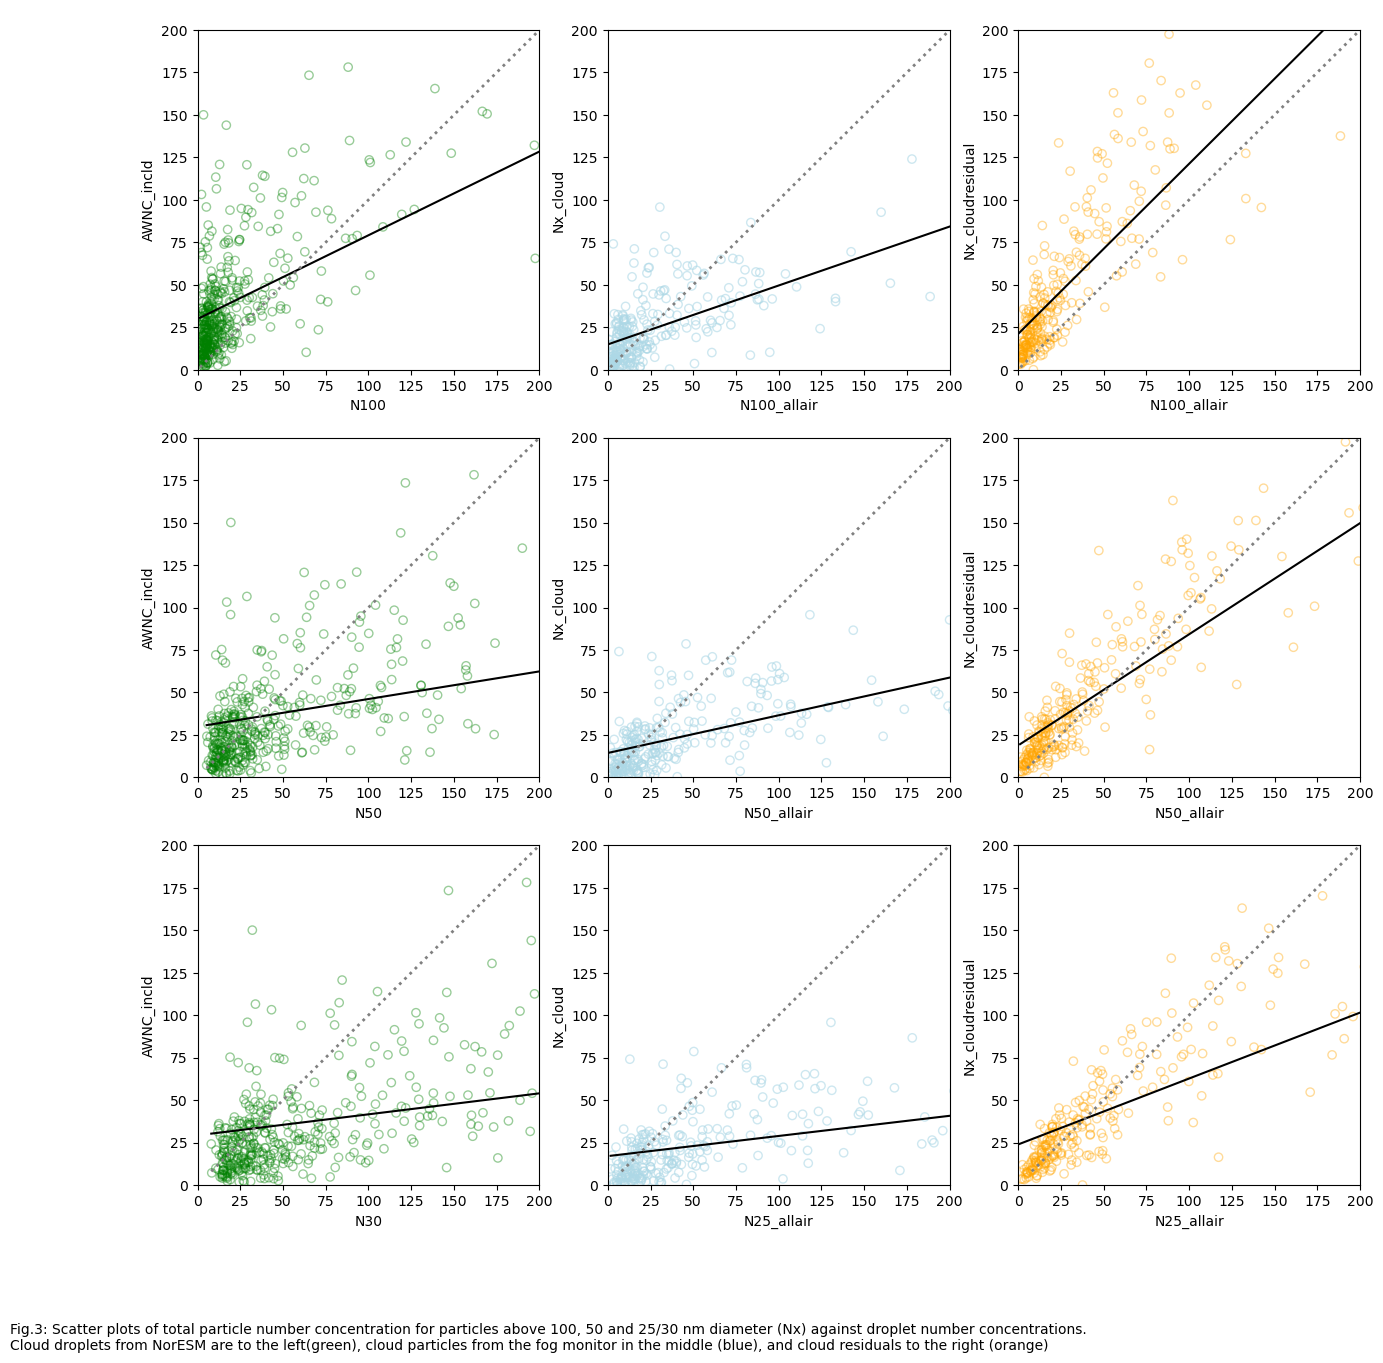

In [38]:
fig, axs = plt.subplots(3,3, figsize=(15,15))

#-------------------------------------------------------------------
ds_nonan.plot.scatter('N100', 'AWNC_incld', alpha=.4, edgecolor='green',facecolor='None', marker='o', ax = axs[0,0])

z0 = np.polyfit(ds_nonan['N100'], ds_nonan['AWNC_incld'],1)
p0 = np.poly1d(z0)
x0=np.linspace(ds_nonan['N100'].min(), ds_nonan['N100'].max())
axs[0,0].plot(x0, p0(x0), c='k')
axs[0,0].plot(x0, x0, c='grey', linestyle=':', linewidth=2)
#-------------------------------------------------------------------
N100_daily_nonan.plot.scatter('N100_allair', 'Nx_cloud', alpha=.6, edgecolor='lightblue',facecolor='None', marker='o', ax=axs[0,1])

z1 = np.polyfit(N100_daily_nonan['N100_allair'], N100_daily_nonan['Nx_cloud'],1)
p1 = np.poly1d(z1)
x1=np.linspace(N100_daily_nonan['N100_allair'].min(), N100_daily_nonan['N100_allair'].max())
axs[0,1].plot(x1, p1(x1), c='k')
axs[0,1].plot(x0, x0, c='grey', linestyle=':', linewidth=2)

#-----------------------------------------------------------------------
N100_daily_nonan.plot.scatter('N100_allair', 'Nx_cloudresidual', alpha=.4, edgecolor='orange',facecolor='None', marker='o', ax=axs[0,2])

z2 = np.polyfit(N100_daily_nonan['N100_allair'], N100_daily_nonan['Nx_cloudresidual'],1)
p2 = np.poly1d(z2)
x2=np.linspace(N100_daily_nonan['N100_allair'].min(), N100_daily_nonan['N100_allair'].max())
axs[0,2].plot(x2, p2(x2), c='k')
axs[0,2].plot(x0, x0, c='grey', linestyle=':', linewidth=2)




    
#------------------------------------------------------------    
#------------------------------------------------------------
ds_nonan.plot.scatter('N50', 'AWNC_incld', alpha=.4, edgecolor='green',facecolor='None', marker='o', ax = axs[1,0])


z0 = np.polyfit(ds_nonan['N50'], ds_nonan['AWNC_incld'],1)
p0 = np.poly1d(z0)
x0=np.linspace(ds_nonan['N50'].min(), ds_nonan['N50'].max())
axs[1,0].plot(x0, p0(x0), c='k')
axs[1,0].plot(x0, x0, c='grey', linestyle=':', linewidth=2)

#-------------------------------------------------------------
N50_daily.plot.scatter('N50_allair', 'Nx_cloud', alpha=.6, edgecolor='lightblue',facecolor='None', marker='o', ax=axs[1,1])

z1 = np.polyfit(N50_daily_nonan['N50_allair'], N50_daily_nonan['Nx_cloud'],1)
p1 = np.poly1d(z1)
x1=np.linspace(N50_daily_nonan['N50_allair'].min(), N50_daily_nonan['N50_allair'].max())
axs[1,1].plot(x1, p1(x1), c='k')
axs[1,1].plot(x0, x0, c='grey', linestyle=':', linewidth=2)


#--------------------------------------------------------------
N50_daily.plot.scatter('N50_allair', 'Nx_cloudresidual', alpha=.4, edgecolor='orange',facecolor='None', marker='o', ax=axs[1,2])

z2 = np.polyfit(N50_daily_nonan['N50_allair'], N50_daily_nonan['Nx_cloudresidual'],1)
p2 = np.poly1d(z2)
x2=np.linspace(N50_daily_nonan['N50_allair'].min(), N50_daily_nonan['N50_allair'].max())
axs[1,2].plot(x2, p2(x2), c='k')
axs[1,2].plot(x0, x0, c='grey', linestyle=':', linewidth=2)

    

    

#-------------------------------------------------------------------    
#-------------------------------------------------------------------
ds_nonan.plot.scatter('N30', 'AWNC_incld', alpha=.4, edgecolor='green',facecolor='None', marker='o', ax = axs[2,0])

z0 = np.polyfit(ds_nonan['N30'], ds_nonan['AWNC_incld'],1)
p0 = np.poly1d(z0)
x0=np.linspace(ds_nonan['N30'].min(), ds_nonan['N30'].max())
axs[2,0].plot(x0, p0(x0), c='k')
axs[2,0].plot(x0, x0, c='grey', linestyle=':', linewidth=2)
#-------------------------------------------------------------------
N25_daily_nonan.plot.scatter('N25_allair', 'Nx_cloud', alpha=.6, edgecolor='lightblue',facecolor='None', marker='o', ax=axs[2,1])

z1 = np.polyfit(N25_daily_nonan['N25_allair'], N25_daily_nonan['Nx_cloud'],1)
p1 = np.poly1d(z1)
x1=np.linspace(N25_daily_nonan['N25_allair'].min(), N25_daily_nonan['N25_allair'].max())
axs[2,1].plot(x1, p1(x1), c='k')
axs[2,1].plot(x0, x0, c='grey', linestyle=':', linewidth=2)

#-----------------------------------------------------------------------
N25_daily_nonan.plot.scatter('N25_allair', 'Nx_cloudresidual', alpha=.4, edgecolor='orange',facecolor='None', marker='o', ax=axs[2,2])

z2 = np.polyfit(N25_daily_nonan['N25_allair'], N25_daily_nonan['Nx_cloudresidual'],1)
p2 = np.poly1d(z2)
x3 = np.linspace(0,200)
x2=np.linspace(N25_daily_nonan['N25_allair'].min(), N25_daily_nonan['N25_allair'].max())
axs[2,2].plot(x3, p2(x3), c='k')
axs[2,2].plot(x0, x0, c='grey', linestyle=':', linewidth=2)
    
    
    
for axi in axs.ravel():
    axi.set_xlim([0,200])
    axi.set_ylim([0,200])
    axi.set_title(' ')

plt.figtext(0, 0,'Fig.3: Scatter plots of total particle number concentration (in #/cm³) for particles above 100, 50 and 25/30 nm diameter (Nx) against droplet number concentrations. \nCloud droplets from NorESM are to the left(green), cloud particles from the fog monitor in the middle (blue), and cloud residuals to the right (orange)')

## **Discussion and outlook**

### **The cloud particle and cloud residual monthly median/mean number concentration conundrum**

The figure from Karlsson et al. (2021) comparing annual median/mean cloud particle and cloud residual concentrations can be found in my Supplemetal Material. According to the paper, the figure shows cloud particle concentrations, multiplied by the GCVI sampling efficiency and integrated above the GCVI cut size, compared to the cloud residual number concentration measured behind the GCVI inlet. To me, this indicates that the GCVI-specific correction *Transmission efficiency* is applied to the fog monitor. The transmission efficiency is determined experimentally by Shingler et al. (2012) for certain diameters, and then interpolated by Karlsson et al. (2021) to cover the whole size range of the Fog monitor (see fig S4 in Karlsson et al. 2021). My interpretation is that to then multiply it with the cloud particles measured by the Fog Monitor would yield a size distribution that is in line with what the GCVI "sees". The *transmission_efficiency_factor* should be size dependent. However, provided in the dataset, it came as a time series, with only one value per time step. As such, I might have missed something about the process deriving this variable. After a lot of head-scratching, and some consulting, I felt like it was time to move on from this, and accept that I could not completely comprehend this part. As stated in the Methods-section, the data was already treated with the correction factors, so it should not impact my further results. 

### **Seasonal concentration density**

From Fig. 2, we see that NorESM is able to reproduce the overall distribution of cloud drop concentration for each season. Autumn and winter is dominated by lower concentrations for all three cloud droplet representations, while higher concentration is found during spring and summer. During summer, the cloud residuals seem to have a more even distribution between low and high concentrations, which is not the case for the cloud particles (fog monitor) nor NorESM. I am not quite sure what could be the cause of this. Differences between the cloud particles and the cloud residuals could arise from the fog monitors tendency to interpret large particles as droplets when the liquid water content is low, but this does not explain the larger concentrations for the cloud residuals. Since I did not separate for temperature here, another bias with the fog monitor is the influence of ice particles. This could be the reason for the high peak (extending out of the figure limits) at low concentrations in winter.

### **Total particle and cloud droplet number concentration**

In Fig.3, it can seem that the regression lines are a bit arbitrary. After trying different methods with the same result, I can not think of a obvious explanation for this. It should be noted that some data points lie outside the figure limits. These are however limited in number, but might impact the calculation of the slope. We could also use the one-to-one line (dashed grey) to evaluate the relationship. It should howerver be noted that we do not expect a one-to-one relationship of the number concentrations along the whole particle number concentration range, because droplet activation, in addition to beind dependent on particle size, is a give and take between water vapor availability and particle number. With this in mind, we can see a fairly strong relationship between cloud droplet number concentration and particle number at low concentrations, both for the measurements, and to a lesser degree in NorESM. For the measurements, this holds true even when integrating from 25 nm, especially for the cloud residuals. This reflects that the Arctic is a pristine environment, where even small droplets get activated. To further investigate this relationship in the measurement data, I think it could be a good idea to look at small particles isolated, for example by integrating from the lower diameter limit up to an upper diameter limit, to exclude the droplets that are activated at larger particle diameters. This way, we could compare the relationship at size ranges that does not ovelap. To do this properly, it would also be of interest to somehow filter the droplet concentration to correspond to smaller particle sizes.

From these plots, it is evident that the relationship between total particle and cloud droplet number concentration is stronger in the measurements than in NorESM, independent from which particle diameter we integrate. We do see that when using N100, there are already quite a lot of activated droplets in NorESM. This indicates that N100 is not a good cloud droplet proxy for NorESM at this location. Here, it looks like N50 is a better proxy. However, the relationship is not very strong at N50 or N30. Another aspect of the NorESM-plots is that there seems to be a gap at low concentrations, maybe indicating that there is a threshold particle concentration for cloud activation in the model.





## **Conclusion**
The dataset assembled and provided by Karlsson et al. (2021) provides a unique insight into particle and cloud droplet characteristics in a site representative of the pristine Arctic. Although the data has already been used for several papers and Linn Karlsens PhD work, there is still a lot of potential for further investigation. During the ten day course in Tjärnö, I spent quite some time getting to know the data set, and the measurement limitations. I am sure further measures could be done to optimalize comparison of the different data I look at here. For this project, I wanted to look into some key elements of aerosol-cloud interactions, and compare the measurement data to a model simulation done with NorESM. I found that NorESM managed to simulate the seasonal evolution of cloud droplet concentration distribution quite well, with lower concentrations dominating in autumn and winter, and higher concentration being more frequent in spring and summer. 
I evaluated the relationship between cloud droplet and particle number concentration for cloud particles from the fog monitor, cloud residuals from the GCVI inlet and total particles from the whole air-inlet, and cloud droplets and particle concentration from NorESM. At consentrations lower than 100 cm⁻³, the cloud residual number concentration reveal a strong relationship with particle concentration, even when including particles down to 25 nm diameter. Cloud particles from the fog monitor plots display a larger spread compared with cloud residuals, and at higher concentrations there are more non-activated particles than cloud particles. 
For NorESM, N100 does not seem to be a good cloud particle proxy, as there are too many cloud droplets compared to particles. N50 does on the other hand seem to yield a better agreement, although the spread is quite large. Compared to N30, NorESM seem to have too few cloud droplets, even at low concentrations.

Although the results in this report can give some indications of the characteristics of aerosol-cloud interactions in the Arctic, a lot more could be done with the data available. To improve and make the results more robust, further diagnostics could be done on the relationship between cloud droplet and particle number concentration, for example alternative approaches of linear regression. 


### **References**

Karlsson L, Krejci R, Koike M, Ebell K, Zieger P (2021) A long-term study of cloud residuals from low-level Arctic clouds. Atmos Chem Phys 21:8933⁠ – ⁠8959. https://doi.org/10.5194/acp-21-8933-2021


Karlsson, Linn
PhD-thesis: Aerosol–cloud interactions in a warming Arctic
Stockholm University, Faculty of Science, Department of Environmental Science.
ORCID iD: 0000-0003-0885-7650

Scikit-learn: Machine Learning in Python
Fabian Pedregosa, Gaël Varoquaux, Alexandre Gramfort, Vincent Michel, Bertrand Thirion, Olivier Grisel, Mathieu Blondel, Peter Prettenhofer, Ron Weiss, Vincent Dubourg, Jake Vanderplas, Alexandre Passos, David Cournapeau, Matthieu Brucher, Matthieu Perrot, Édouard Duchesnay; 12(85):2825−2830, 2011.

Shingler, T., Dey, S., Sorooshian, A., Brechtel, F. J., Wang, Z., Metcalf, A., Coggon, M., Mülmenstädt, J., Russell, L. M., Jonsson, H. H., and Seinfeld, J. H.: Characterisation and airborne deployment of a new counterflow virtual impactor inlet, Atmos. Meas. Tech., 5, 1259–1269, https://doi.org/10.5194/amt-5-1259-2012, 2012. a, b, c, d, e, f, g, h, i, j, k, l, m, n

### **Acknowledgements**

First, I want to thank Linn Karlsson and her team at Stockholm University for assembling and providing the data.
I then want to thank our group assistant Sara Blichner for being such a resource and a big inspiration in working with aerosol-cloud science. I also want to thank Stefan for the cooperation in our group. Lastly, a big thanks to Paul Ziegler and Michael Sculz for organizing this course, and for letting me attend. And thanks also to the rest of the participants of the course, who made our stay in Tjärnö a really intense, but good experience.

## **Supplementary material**

### **S1: Cloud particle/residual annual mean/median number concentration from Karlsson et al. (2021)**

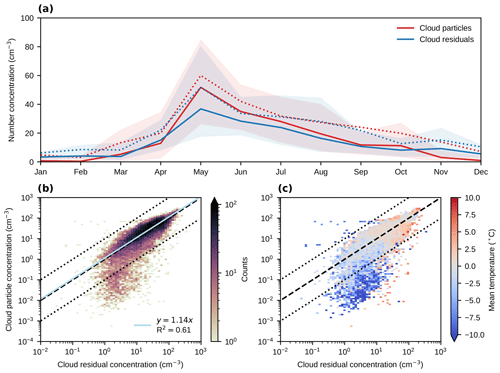

Figure 2: Comparison of cloud residual and cloud particle number concentrations. (a) Monthly averages of cloud residual number concentrations as measured behind the GCVI (blue) and corresponding cloud particle number concentrations derived from the FM-120 fog monitor measurements and the transmission efficiency of the GCVI inlet (red). Solid and dotted lines show median and mean values, respectively, and shaded areas indicate the 25th to 75th percentile ranges. (b) Density scatterplot of cloud residual vs. cloud particle number concentrations, including an orthogonal distance linear regression (grey line). (c) The same as (b) but colour coded by the average temperature instead of the data point density. In (b) and (c), the dashed black line represents the 1:1 line, and the dotted lines represent 10:1 and 1:10 lines. The transmission efficiency and cut size of the GCVI inlet (Shingler et al., 2012) has been included in the calculation of the cloud particle number concentration in all panels (note that the absolute ambient cloud particle concentrations are therefore higher than those shown in the figure; see text).